<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Merge/merge_random%20select%20Data_25%20S_%20250k%20Train%20sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  '''
  model: 3 Dense layer after Concatenate
  
Train_Data_number = 250000
Test_Data_number = 50000
subject_number=25 (20+5)

test 1 - loss, acc :[0.2430, 0.93166]
test 2 - loss, acc :[4.3289, 0.59517]
test 3 - loss, acc :[1.2540, 0.75434]
test 4 - loss, acc :[8.0151, 0.5]
  
  '''

In [44]:
! pip install mne

In [45]:

import matplotlib

from matplotlib import pyplot as plt
import numpy as np

import math

import keras
from keras.utils import to_categorical

import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

Automatically created module for IPython interactive environment


In [75]:


Train_Data_number = 250000
Test_Data_number = 50000



subject_number=25

new_subject_number = subject_number//5 # 
#index_new_subject = 0

train_subject_number = subject_number - new_subject_number
new_subject_start_index = train_subject_number
task_index = [1] # task: REO
task_number = len(task_index)

# channels 
list_channel = [60]
ch_number = len(list_channel)

task_time = 60

sampel_number_per_sec = 160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160

inner_sample_shift = 5 # inner step len
outer_sample_shift = 5 # outer step len
window_len= 20

new_subject_start_index

20

In [76]:
# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
    for j in range(task_number):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)

[........................................] 100.00% (  1.2 MB,   1.2 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) -
[........................................] 100.00% (  1.2 MB,   1.0 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) -
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) /
[........................................] 100.00% (  1.2 MB,   1.0 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.0 MB/s) /
Extracting E

In [77]:
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1

test_img_number = math.floor(subject_img_number * 0.15)
test_img_start_index=subject_img_number - test_img_number
train_img_number =  test_img_start_index 

test_img_start_index


1590

In [0]:

def normalize_channel_data(ch , i, ch_min, ch_max):
    ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
    return ch

In [79]:
# All data
DataChannelsRaw = np.zeros((subject_number, ch_number,total_sampel_number), dtype = float)

for i in range(train_subject_number):
  for  j in range(ch_number):
    DataChannelsRaw[i][j], times =list_rawdata[i][0][list_channel[j],:total_sampel_number]
DataChannelsRaw_t = DataChannelsRaw.copy()

#normal all data
for i in range(subject_number):
  ch_max =[]
  ch_min =[]
  for  j in range(ch_number):    
    ch_max = np.append(ch_max, max(DataChannelsRaw_t[i][j])) # max for each cannel
    ch_min = np.append(ch_min, min(DataChannelsRaw_t[i][j])) # min for each cannel
    
    # Normalize Channels
    DataChannelsRaw_t[i][j]=normalize_channel_data(DataChannelsRaw_t[i][j], j, ch_min, ch_max)
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
DataChannelsRaw_t.shape

(25, 1, 9600)

In [0]:
def Extract_Data(rand_subject, rand_sample):

  Rand_Data =  np.zeros((ch_number, window_len, sampel_number_per_sec), dtype = float)
  for i in range(ch_number):
    for z in range (window_len):
      ExtractedData = DataChannelsRaw_t[rand_subject][i, rand_sample + z*inner_sample_shift: sampel_number_per_sec + rand_sample + z*inner_sample_shift] 
      Rand_Data[i][z] = ExtractedData
      
  return Rand_Data

In [0]:
def Fill_input_array(Data_number, first_index_subjectA, last_index_subjectA, first_index_sampleA, last_index_sampleA,   first_index_subjectB, last_index_subjectB, first_index_sampleB, last_index_sampleB):
  loop_counter = int(Data_number/2)
  
  input1 = np.zeros((Data_number, ch_number, window_len , sampel_number_per_sec), dtype = float)
  input2 = np.zeros((Data_number, ch_number, window_len, sampel_number_per_sec), dtype = float)
  input_label=[]
  
  for r in range(loop_counter):
    # select random subject and sample A
    rand_subjectA = random.randint(first_index_subjectA, last_index_subjectA)
    rand_sample1_A= random.randint(first_index_sampleA, last_index_sampleA) * outer_sample_shift
    rand_sample2_A= random.randint(first_index_sampleA, last_index_sampleA) * outer_sample_shift

    # 1: Select random data from subjectA 
    rand_Data1_subjectA = Extract_Data(rand_subjectA, rand_sample1_A)
    input1[r*2:r*2+2] = rand_Data1_subjectA

    # 2: Select random data from subjectA 
    rand_Data2_subjectA = Extract_Data(rand_subjectA, rand_sample2_A)
    input2[r*2] = rand_Data2_subjectA

    #set label 1
    input_label = np.append(input_label, 1) 



    # select random subject and sample B
    rand_sampleB= random.randint(first_index_sampleB, last_index_sampleB) * outer_sample_shift
    rand_subjectB = random.randint(first_index_subjectB, last_index_subjectB)
    # A != B
    while rand_subjectA == rand_subjectB:
      rand_subjectB = random.randint(first_index_subjectB, last_index_subjectB)

    # Select random data from subjectB
    rand_Data_subjectB = Extract_Data(rand_subjectB, rand_sampleB)
    input2[r*2+1] = rand_Data_subjectB

    #set label 0
    input_label = np.append(input_label, 0)
    
  return input1, input2, input_label


In [83]:
# **create Train Data 

Train_input1, Train_input2, train_label = Fill_input_array(Train_Data_number, 0, train_subject_number-1, 0, train_img_number-1, 0, train_subject_number-1, 0, train_img_number-1)

train_label = to_categorical(train_label, 2)
train_label


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
validation_index = math.floor( Train_Data_number * 0.2)


# validation & train

#train
x_train_1 =Train_input1[validation_index:]
x_train_2 =Train_input2[validation_index:]

y_train =train_label[validation_index:]

#validation
x_validation_1 =Train_input1[:validation_index]
x_validation_2 =Train_input2[:validation_index] 

y_valid =train_label[:validation_index]

#x_valid.shape

In [0]:

from keras import layers
from keras import models
from keras import regularizers
#from keras.layers import Dense, Merge
from keras.layers import *
from keras.models import Model


cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,sampel_number_per_sec), data_format= "channels_first" ))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
print(cnn1.output.shape)
cnn1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
print(cnn1.output.shape)
cnn1.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
cnn1.add(layers.Flatten())
print(cnn1.output.shape)


cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,sampel_number_per_sec), data_format= "channels_first" ))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
print(cnn2.output.shape)
cnn2.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
print(cnn2.output.shape)
cnn2.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
cnn2.add(layers.Flatten())
print(cnn2.output.shape)

mergedOut = Concatenate()([cnn1.output,cnn2.output])

#mergedOut = Flatten()(mergedOut)    
mergedOut = Dense(512, activation='relu')(mergedOut)
mergedOut = Dropout(.5)(mergedOut)
mergedOut = Dense(128, activation='relu')(mergedOut)
mergedOut = Dense(16, activation='relu')(mergedOut)
# output layer
mergedOut = Dense(2, activation='sigmoid')(mergedOut)

newModel = Model([cnn1.input,cnn2.input], mergedOut)

#model = models.Sequential()
#model.add(layers.Concatenate([cnn1,cnn2]))
#model.add(layers.Dense(512, activation = 'relu'))
#model.add(layers.Dropout(0.5))
#print(model.output.shape)
#model.add(layers.Dense(2, activation = 'sigmoid'))
#print(model.output.shape)


from keras import optimizers

newModel.compile(loss= 'binary_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

In [0]:
newModel.summary()

In [87]:
history = newModel.fit(
        [x_train_1, x_train_2],
        y_train,
        epochs = 15,
        batch_size = 50,
        validation_data = ([x_validation_1, x_validation_2], y_valid)
)

Train on 200000 samples, validate on 50000 samples
Epoch 1/15
200000/200000 [==============================] - 185s 925us/step - loss: 0.5710 - acc: 0.6388 - val_loss: 0.3526 - val_acc: 0.8431
Epoch 2/15
200000/200000 [==============================] - 184s 921us/step - loss: 0.2873 - acc: 0.8820 - val_loss: 0.2561 - val_acc: 0.8968
Epoch 3/15
200000/200000 [==============================] - 184s 921us/step - loss: 0.2515 - acc: 0.9003 - val_loss: 0.2244 - val_acc: 0.9097
Epoch 4/15
200000/200000 [==============================] - 184s 920us/step - loss: 0.2071 - acc: 0.9218 - val_loss: 0.1883 - val_acc: 0.9275
Epoch 5/15
200000/200000 [==============================] - 184s 919us/step - loss: 0.1643 - acc: 0.9400 - val_loss: 0.1454 - val_acc: 0.9472
Epoch 6/15
200000/200000 [==============================] - 184s 919us/step - loss: 0.1395 - acc: 0.9512 - val_loss: 0.1200 - val_acc: 0.9598
Epoch 7/15
200000/200000 [==============================] - 184s 919us/step - loss: 0.1236 - acc:

In [0]:
import gc
gc.collect()

In [88]:
# **create Test Data 1 ( A : from train subject , B: from train subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, 0, train_subject_number-1, test_img_start_index, subject_img_number-1, 0, train_subject_number-1, test_img_start_index, subject_img_number-1)

test_label = to_categorical(test_label, 2)
newModel.evaluate([test_input1, test_input2], test_label)

50000/50000 [==============================] - 15s 300us/step


[0.24304980319708586, 0.93166]

In [89]:
# **create Test Data 2 ( A : from train subject , B: from new subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, 0, train_subject_number-1, test_img_start_index, subject_img_number-1, new_subject_start_index, subject_number-1, 0, subject_img_number-1)
test_label = to_categorical(test_label, 2)

newModel.evaluate([test_input1, test_input2], test_label)

50000/50000 [==============================] - 15s 305us/step


[4.328945310974121, 0.59517]

In [90]:
# **create Test Data 3 ( A : from new subject , B: from train subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, new_subject_start_index, subject_number-1, 0, subject_img_number-1, 0, train_subject_number-1, test_img_start_index, subject_img_number-1)
test_label = to_categorical(test_label, 2)

newModel.evaluate([test_input1, test_input2], test_label)

50000/50000 [==============================] - 15s 302us/step


[1.254060850725174, 0.75434]

In [91]:
# **create Test Data 4 ( A : from new subject , B: from new subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, new_subject_start_index, subject_number-1, 0, subject_img_number-1, new_subject_start_index, subject_number-1, 0, subject_img_number-1)

test_label = to_categorical(test_label, 2)
newModel.evaluate([test_input1, test_input2], test_label)

50000/50000 [==============================] - 15s 305us/step


[8.015119552612305, 0.5]

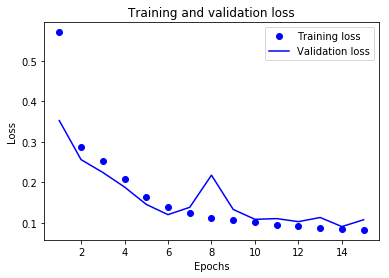

In [92]:
import matplotlib.pyplot as plt

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

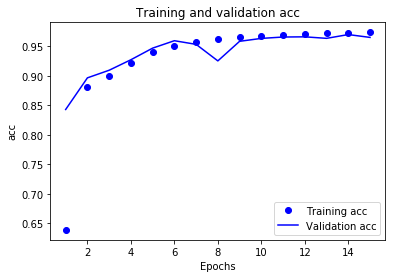

In [93]:
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()